# Проект: Разработка интерактивного сервиса для классификации изображений на CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

100%|██████████| 170M/170M [14:49<00:00, 192kB/s]  


Device: cpu


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32x32
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)                            # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 16x16
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))  # после второго пулла: 8x8
        x = nn.ReLU()(self.bn3(self.conv3(x)))             # оставляем 8x8
        x = torch.flatten(x, 1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

num_epochs = 20
train_losses = []
test_accs = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    t0 = time.time()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    # eval
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    test_accs.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} loss={train_losses[-1]:.4f} test_acc={acc:.2f} time={time.time()-t0:.1f}s")


Epoch 1/20 loss=1.3749 test_acc=61.76 time=120.7s
Epoch 2/20 loss=1.0296 test_acc=67.56 time=94.6s
Epoch 3/20 loss=0.9006 test_acc=70.60 time=96.1s
Epoch 4/20 loss=0.8310 test_acc=70.86 time=94.4s
Epoch 5/20 loss=0.7650 test_acc=72.67 time=98.7s
Epoch 6/20 loss=0.7307 test_acc=77.16 time=97.2s
Epoch 7/20 loss=0.6870 test_acc=76.91 time=95.9s
Epoch 8/20 loss=0.6553 test_acc=76.77 time=95.8s
Epoch 9/20 loss=0.6288 test_acc=77.39 time=135.4s
Epoch 10/20 loss=0.6094 test_acc=78.45 time=119.5s
Epoch 11/20 loss=0.5851 test_acc=77.83 time=107.3s
Epoch 12/20 loss=0.5678 test_acc=79.62 time=120.1s
Epoch 13/20 loss=0.5485 test_acc=79.75 time=119.2s
Epoch 14/20 loss=0.5359 test_acc=80.23 time=109.6s
Epoch 15/20 loss=0.5243 test_acc=79.99 time=106.0s
Epoch 16/20 loss=0.5105 test_acc=80.09 time=120.2s
Epoch 17/20 loss=0.4932 test_acc=79.98 time=126.9s
Epoch 18/20 loss=0.4819 test_acc=80.77 time=100.7s
Epoch 19/20 loss=0.4697 test_acc=80.57 time=101.2s
Epoch 20/20 loss=0.4623 test_acc=82.44 time=102

In [4]:
PATH = '../cifar_net.pth'
torch.save(net.state_dict(), PATH)
print("Saved:", PATH)


Saved: ../cifar_net.pth


Text(0.5, 1.0, 'Test accuracy (%)')

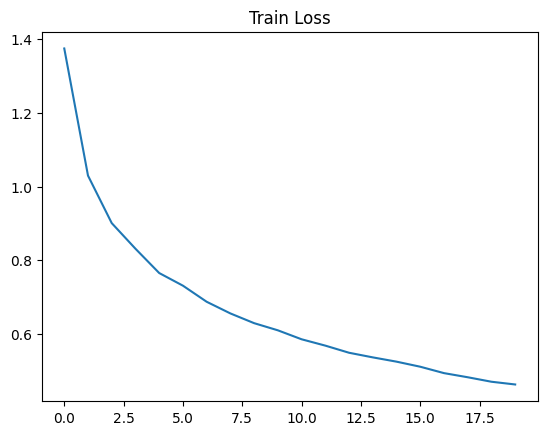

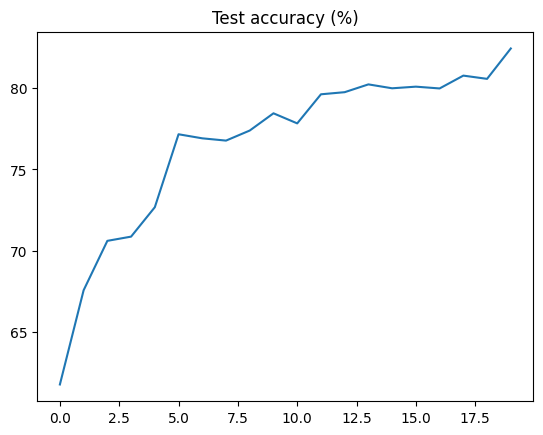

In [5]:
plt.plot(train_losses); plt.title("Train Loss")
plt.figure(); plt.plot(test_accs); plt.title("Test accuracy (%)")